
## Prodigy Infotech Task 4
##### Image to Image Translation with cGAN

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
# for the dataset, we will first declare some global variables
batch_size = 16
epoch_count = 50
noise_dim = 100
n_class = 10
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
img_size = 32

# Load the dataset
(X_train, y_train), (_, _) = cifar10.load_data()

# Normalize the data
X_train = (X_train - 127.5) / 127.5

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)


170498071/170498071 [==============================] - 23s 0us/step


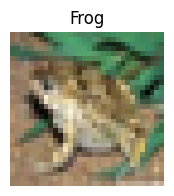

In [3]:
# plotting a random image from the dataset
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

In [4]:
# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
	real_loss = bce_loss(tf.ones_like(real), real)
	fake_loss = bce_loss(tf.zeros_like(fake), fake)
	total_loss = real_loss + fake_loss
	return total_loss

# Generator Loss
def generator_loss(preds):
	return bce_loss(tf.ones_like(preds), preds)

# Optimiser for both Generator and Dsicriminator 
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [5]:
def build_generator():

# label input
	in_label = tf.keras.layers.Input(shape=(1,))

	# create an embedding layer for all the 10 classes in the form of a vector 
	# of size 50
	li = tf.keras.layers.Embedding(n_class, 50)(in_label)

	n_nodes = 8 * 8
	li = tf.keras.layers.Dense(n_nodes)(li)
	# reshape the layer
	li = tf.keras.layers.Reshape((8, 8, 1))(li)

	# image generator input
	in_lat = tf.keras.layers.Input(shape=(noise_dim,))

	n_nodes = 128 * 8 * 8
	gen = tf.keras.layers.Dense(n_nodes)(in_lat)
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
	gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

	# merge image gen and label input
	merge = tf.keras.layers.Concatenate()([gen, li])

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(merge) # 16x16x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(gen) # 32x32x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	out_layer = tf.keras.layers.Conv2D(
		3, (8, 8), activation='tanh', padding='same')(gen) # 32x32x3

	model = Model([in_lat, in_label], out_layer)
	return model


g_model = build_generator()
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 8192)                 827392    ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                              

In [9]:
def build_discriminator():
	
    # label input
    in_label = tf.keras.layers.Input(shape=(1,))
    #This vector of size 50 will be learnt by the discriminator
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)
    
    n_nodes = img_size * img_size 
    li = tf.keras.layers.Dense(n_nodes)(li) 
    
    li = tf.keras.layers.Reshape((img_size, img_size, 1))(li) 
    
    
    # image input
    in_image = tf.keras.layers.Input(shape=(img_size, img_size, 3)) 
    
    merge = tf.keras.layers.Concatenate()([in_image, li]) 
    
    
    #We will combine input label with input image and supply as inputs to the model. 
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) 
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) 
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    
    fe = tf.keras.layers.Flatten()(fe) 
    
    fe = tf.keras.layers.Dropout(0.4)(fe)
    
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)
    
    # define model the model. 
    model = Model([in_image, in_label], out_layer)
    	
    return model


d_model = build_discriminator()
d_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1, 1024)              52224     ['embedding_1[0][0]']         
                                                                                                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                            

In [10]:
# Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):
	
	real_images, real_labels = dataset
	# Sample random points in the latent space and concatenate the labels.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	generated_images = g_model([random_latent_vectors, real_labels])

	# Train the discriminator.
	with tf.GradientTape() as tape:
		pred_fake = d_model([generated_images, real_labels])
		pred_real = d_model([real_images, real_labels])
		
		d_loss = discriminator_loss(pred_real, pred_fake)
	
	grads = tape.gradient(d_loss, d_model.trainable_variables)
	# print(grads)
	d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

	#-----------------------------------------------------------------#
	
	# Sample random points in the latent space.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	
	# Train the generator
	with tf.GradientTape() as tape:
		fake_images = g_model([random_latent_vectors, real_labels])
		predictions = d_model([fake_images, real_labels])
		g_loss = generator_loss(predictions)
	
	grads = tape.gradient(g_loss, g_model.trainable_variables)
	g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
	
	return d_loss, g_loss

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

# Assuming noise_dim and tags are defined elsewhere in your code
# noise_dim: dimension of the noise vector
# tags: class labels for the images

def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(n_class, num_samples, figsize=(10, 20)) 
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in range(n_class):
        random_noise = tf.random.normal(shape=(num_samples, noise_dim))
        label = tf.ones(num_samples) * l  # Create a label for the current class
        gen_imgs = g_model.predict([random_noise, label])

        for j in range(num_samples):
            img = image.array_to_img(gen_imgs[j], scale=True)
            axes[l, j].imshow(img)
            axes[l, j].yaxis.set_ticks([])
            axes[l, j].xaxis.set_ticks([])
            if j == 0:
                axes[l, j].set_ylabel(tags[l])  # Set the label for the class

    plt.show()

Epoch:  50


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [34:27<00:00,  1.51it/s]


1/1 [==============================] - 0s 62ms/step


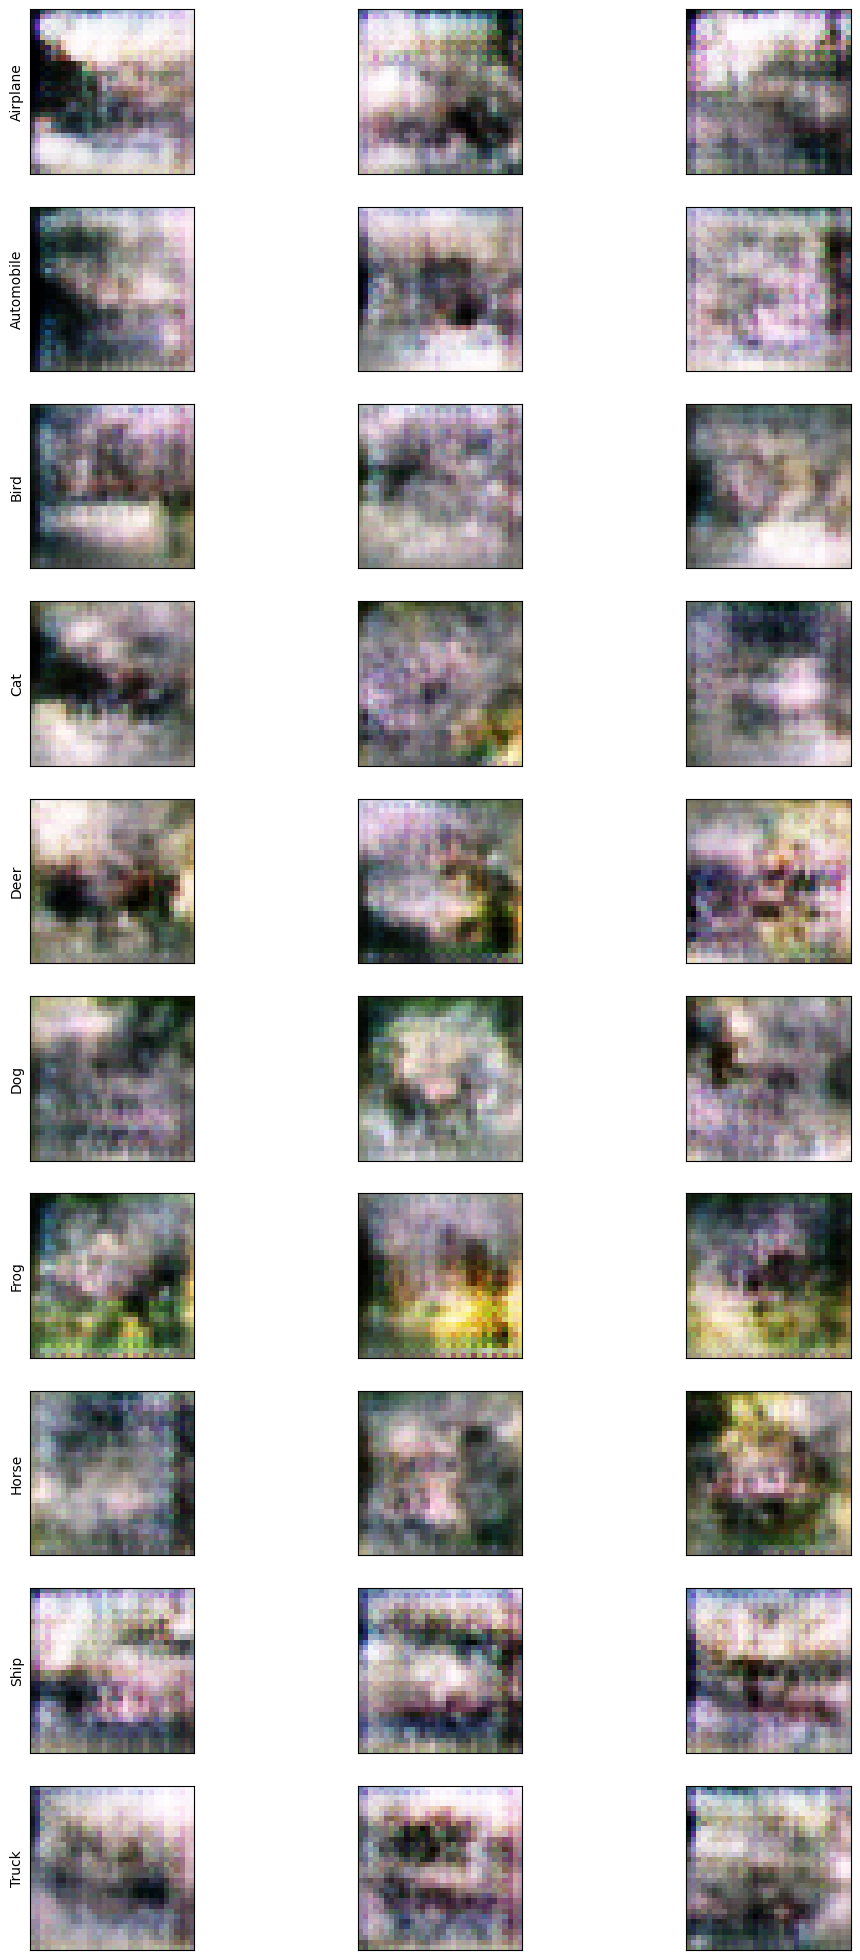

Epoch: 0 -- Generator Loss: 0.8793497085571289, Discriminator Loss: 1.2917450666427612

Took 2075.501990556717 seconds. 


Epoch:  50


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [37:18<00:00,  1.40it/s]


1/1 [==============================] - 0s 65ms/step


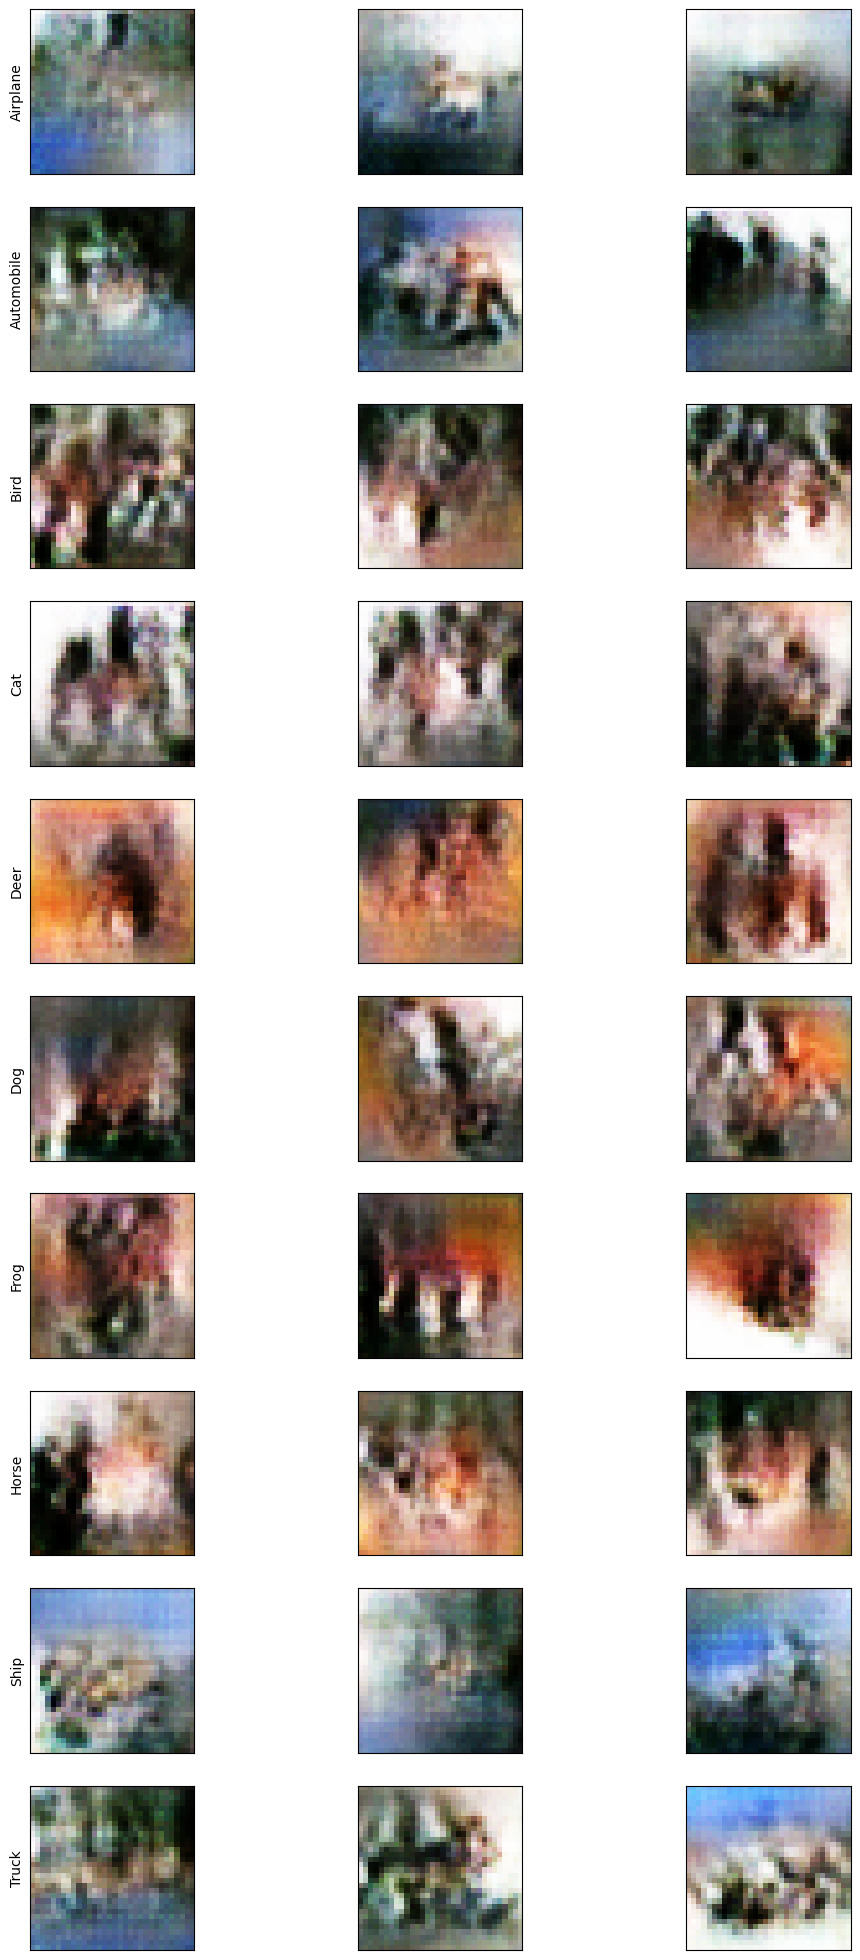

Epoch: 1 -- Generator Loss: 0.8525828123092651, Discriminator Loss: 1.3092753887176514

Took 2254.2199108600616 seconds. 


Epoch:  50


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [37:59<00:00,  1.37it/s]


1/1 [==============================] - 0s 47ms/step


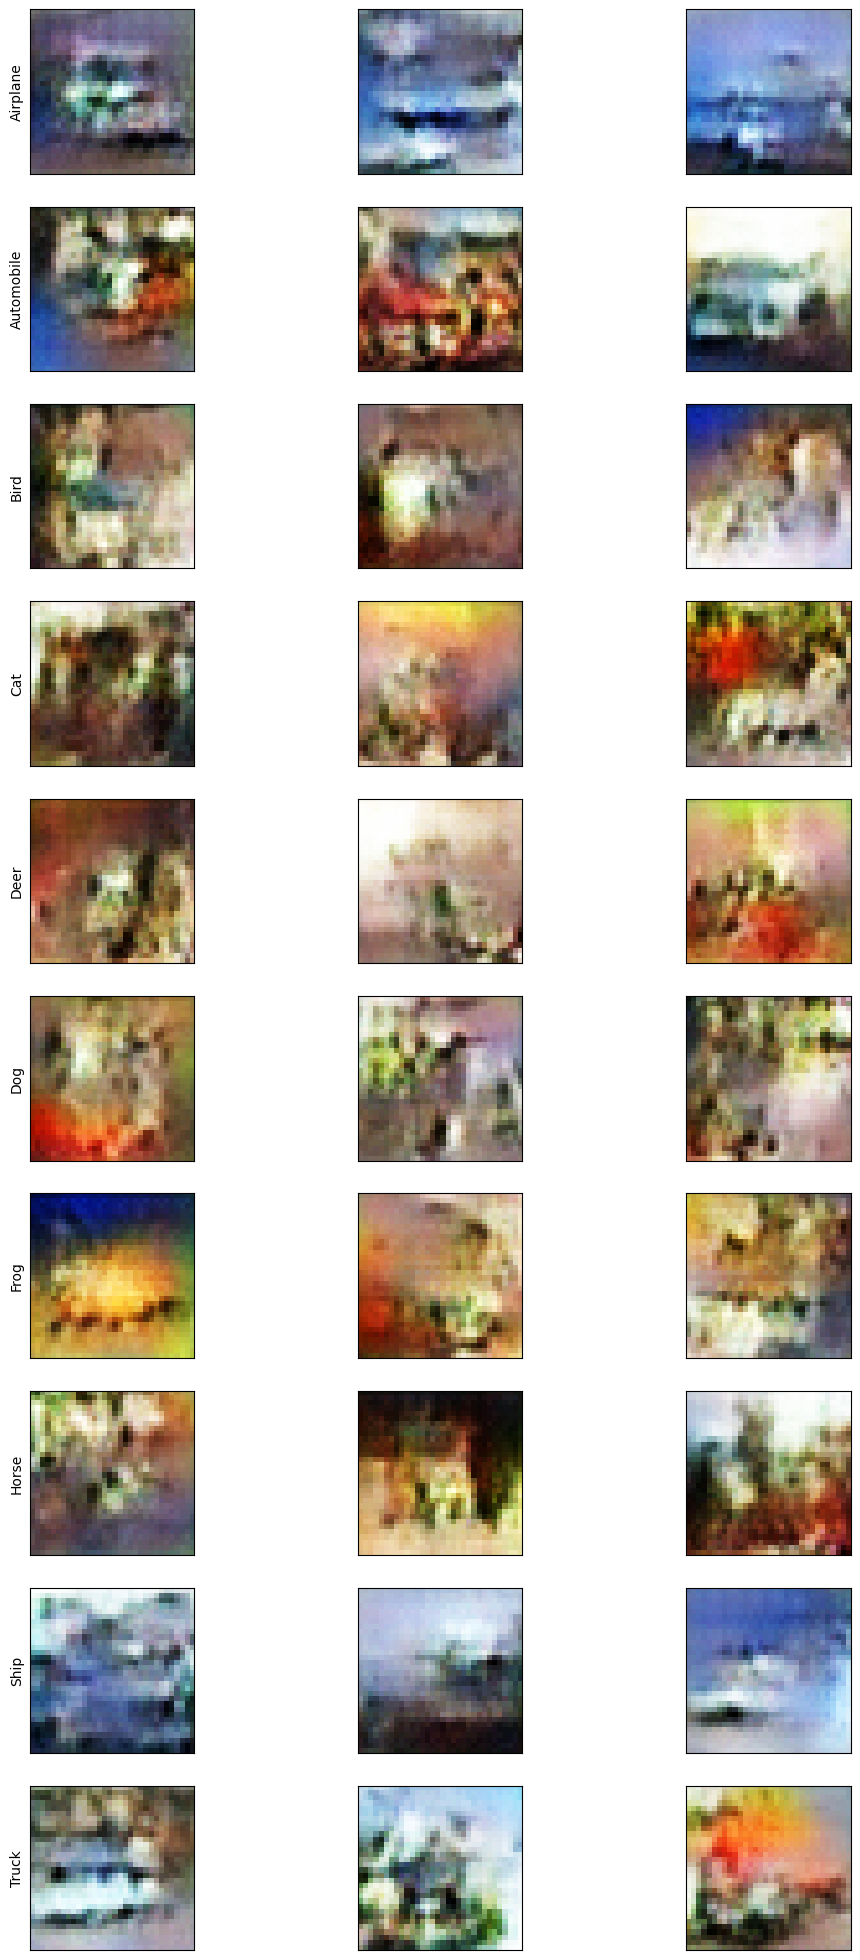

Epoch: 2 -- Generator Loss: 0.8348187208175659, Discriminator Loss: 1.319386601448059

Took 2284.8617811203003 seconds. 


Epoch:  50


 44%|██████████████████████████████████▏                                           | 1371/3125 [14:56<17:56,  1.63it/s]

In [ ]:
def train(dataset, epochs=epoch_count):

	for epoch in range(epochs):
		print('Epoch: ', epochs)
		d_loss_list = []
		g_loss_list = []
		q_loss_list = []
		start = time.time()
		
		itern = 0
		for image_batch in tqdm(dataset):
			d_loss, g_loss = train_step(image_batch)
			d_loss_list.append(d_loss)
			g_loss_list.append(g_loss)
			itern=itern+1
				
		show_samples(3, n_class, g_model)
			
		print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
		print (f'Took {time.time()-start} seconds. \n\n')
		

train(dataset, epochs=epoch_count)